In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 30.71 MiB/s, done.
Resolving deltas: 100% (2656/2656), done.
Updating files: 100% (248/248), done.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
)
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [4]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [5]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
    ]
)
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [6]:
# Set the batch size
BATCH_SIZE = (
    32  # this is lower than the ViT paper but it's because we're starting small
)

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,  # use manually created transforms
    batch_size=BATCH_SIZE,
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a2ffcd8f230>,
 ['pizza', 'steak', 'sushi'])

In [7]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

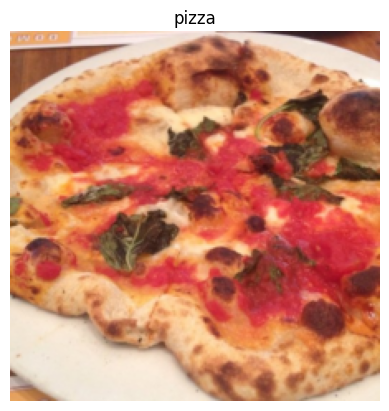

In [8]:
plt.imshow(
    image.permute(1, 2, 0)
)  # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

In [9]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)

In [11]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(embedding_layer_input_shape)
print(embedding_layer_output_shape)

(224, 224, 3)
(196, 768)


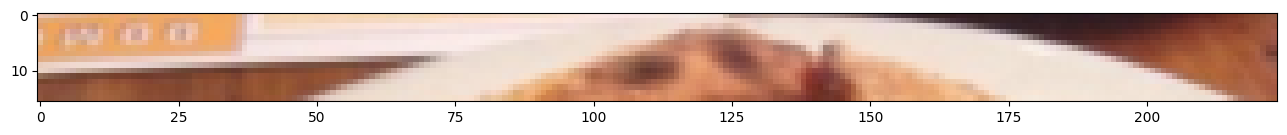

In [12]:
image_permuted = image.permute(1, 2, 0)
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:16, :, :])

In [30]:
def patchifying(img):
    img_size = 224
    patch_size = 16
    image_permuted = img.permute(1, 2, 0)

    fig, axs = plt.subplots(
        nrows=img_size // patch_size,
        ncols=img_size // patch_size,
        sharex=True,
        sharey=True,
    )

    counter = 0
    next_patch_size_length = patch_size
    while next_patch_size_length <= image_permuted.shape[0]:
        next_patch_size_width = patch_size
        while next_patch_size_width <= image_permuted.shape[1]:
            ax = axs.flat[counter]
            ax.imshow(
                image_permuted[
                    next_patch_size_length - patch_size:next_patch_size_length,
                    next_patch_size_width - patch_size:next_patch_size_width,
                    :,
                ]
            )
            ax.set_xlabel(counter + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            next_patch_size_width += patch_size
            counter += 1
        next_patch_size_length += patch_size


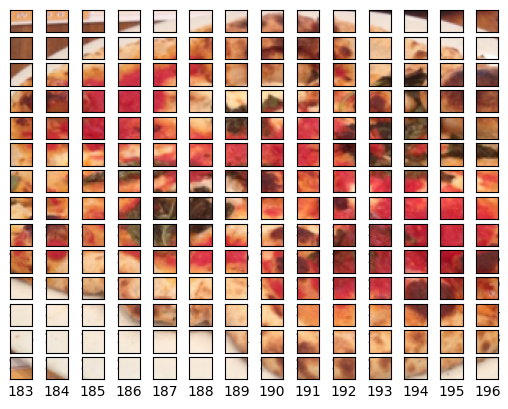

In [31]:
patchifying(image)

In [48]:
class Patchifier(nn.Module):
    def __init__(self, channel_size=3, patch_size=16, img_size=224) -> None:
        super().__init__()

        self.patch_size = patch_size
        self.image_size = img_size
        self.channgel_size = channel_size
        self.conv = nn.Conv2d(
            in_channels=3, out_channels=768, kernel_size=patch_size, stride=patch_size
        )
        self.flattening = nn.Flatten()
        self.linear = nn.Linear(
            in_features=768 * 14 * 14,
            out_features=768 * 14 * 14,
        )

    def forward(self, x):
        img_array = []
        next_patch_size_length = patch_size
        while next_patch_size_length <= image_permuted.shape[0]:
            next_patch_size_width = patch_size
            while next_patch_size_width <= image_permuted.shape[1]:

                img_array.append(
                    self.linear(
                        self.flattening(
                            self.conv(
                                x[
                                    :,
                                    next_patch_size_length
                                    - patch_size : next_patch_size_length,
                                    next_patch_size_width
                                    - patch_size : next_patch_size_width,
                                ]
                            )
                        )
                    )
                )
                next_patch_size_width += patch_size
            next_patch_size_length += patch_size

        return torch.stack(img_array)

In [49]:
model = Patchifier()
model(image.unsqueeze(0))

: 

: 

: 